In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


# This is an attempt on testing the Cats vs Dogs dataset on a smaller version of the GooleNet
First We Extract the files into the working directory

In [2]:
import zipfile

train_zip='/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip'
zip_ref=zipfile.ZipFile(train_zip,'r')
zip_ref.extractall('/kaggle/working/')

**Lets view our image files**

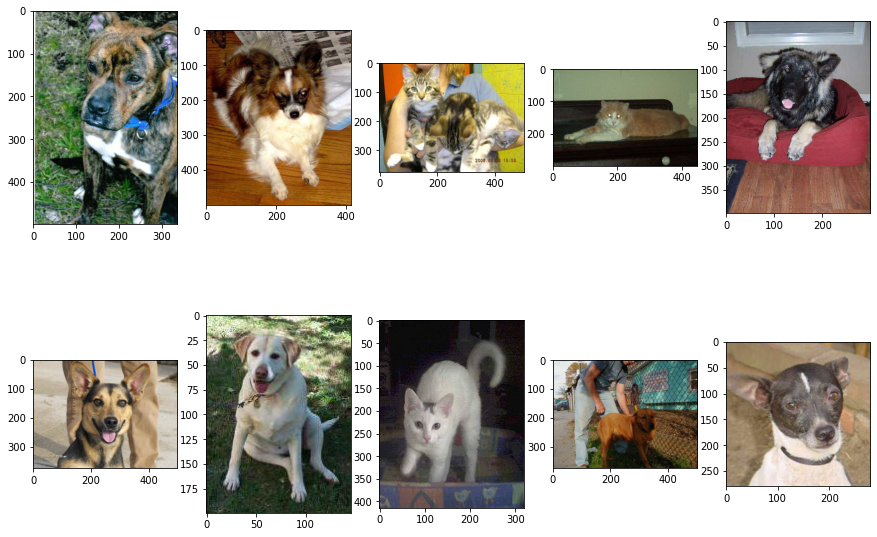

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

work='/kaggle/working'
train_path='/kaggle/working/train/'
file_items=os.listdir(train_path)

fig,([ax1,ax2,ax3,ax4,ax5],[ax6,ax7,ax8,ax9,ax10])=plt.subplots(2,5,figsize=(15,10))
figs=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]

for i in range(10):
    k=mpimg.imread(os.path.join(train_path,file_items[i]))
    figs[i].imshow(k)


We sort the files into categories by checking the file name

In [4]:
import re

def labeler(value):
    cat_or_dog=re.findall('\w{3}',value)[0].lower()
    if cat_or_dog=='dog':
        return 1
    elif cat_or_dog=='cat':
        return 0
    else:
        return None

# listed=['dog.10667.jpg','cat']
labels=list(map(labeler,file_items))

Creating the directories for separating the images into Train & Valid set of two categories  

**code to create directory**

In [5]:
os.mkdir(f'{work}/valid')
os.mkdir(f'{work}/valid/dogs')
os.mkdir(f'{work}/valid/cats')
os.mkdir(f'{train_path}dogs')
os.mkdir(f'{train_path}cats')


The following code is to separate the data into train and test sets

In [6]:
df_dc=pd.DataFrame([file_items,labels],['file','label'])
df_dc=df_dc.transpose()
df_dc.iloc[3]['label']
valid_df=df_dc.iloc[-6250:]
train_df=df_dc.iloc[:-6250] 


Lets transfer the cats and dogs pictures into thier respective directories

In [7]:
#train_directory
cat_train=f'{train_path}cats/'
dog_train=f'{train_path}dogs/'

#valid_directory
cat_val=f'{work}/valid/cats/'
dog_val=f'{work}/valid/dogs/'

def change_dir_train(value):
    if value.label==0:
        os.rename(f'{train_path}{value.file}',f'{cat_train}{value.file}')
    elif value.label==1:
        os.rename(f'{train_path}{value.file}',f'{dog_train}{value.file}')
        
def change_dir_valid(value):
    if value.label==0:
        os.rename(f'{train_path}{value.file}',f'{cat_val}{value.file}')
    elif value.label==1:
        os.rename(f'{train_path}{value.file}',f'{dog_val}{value.file}')
        
#send to directory
train_df.apply(change_dir_train,axis=1)
valid_df.apply(change_dir_valid,axis=1)

18750    None
18751    None
18752    None
18753    None
18754    None
         ... 
24995    None
24996    None
24997    None
24998    None
24999    None
Length: 6250, dtype: object

Checking the number of items in each of the directories

In [8]:
dog_train_path='/kaggle/working/train/dogs'
cat_train_path='/kaggle/working/train/cats'
dog_valid_path='/kaggle/working/valid/dogs'
cat_valid_path='/kaggle/working/valid/cats'

dog_train_items=os.listdir(dog_train_path)
cat_train_items=os.listdir(cat_train_path)
cat_val_items=os.listdir(cat_valid_path)
dog_val_items=os.listdir(dog_valid_path)
print(f'''train set items for dogs: {len(dog_train_items)}
train set items for cats: {len(cat_train_items)}
valid set items for dogs: {len(dog_val_items)}
valid set items for cats: {len(cat_val_items)}''')

train set items for dogs: 9356
train set items for cats: 9394
valid set items for dogs: 3144
valid set items for cats: 3106


**code to remove all directories**

In [9]:
# import shutil
# shutil.rmtree('/kaggle/working/valid')


**Image preprocessing**

Image preprocessing is only done to identify the categories and rescaling..
Not much Data Augmentation was done here since our goal was just to test the network.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1/255)
valid_datagen=ImageDataGenerator(rescale=1/255)


train_generator=train_datagen.flow_from_directory(
    train_path,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary')

valid_generator=valid_datagen.flow_from_directory(
    f'{work}/valid',
    target_size=(150,150),
    batch_size=64,
    class_mode='binary')

Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.


# Making the ConvNet 

Creating inception layers narrows down the computing cost and the number of parameters


In [11]:

import tensorflow as tf
from tensorflow import keras

input=keras.layers.Input(shape=(150,150,3))
layer0=keras.layers.Conv2D(32,(3,3),activation='relu')(input)
layer1=keras.layers.MaxPooling2D(2,2)(layer0)
#1st inception layer
pool=keras.layers.MaxPooling2D(3,1)(layer1)
pool_transfer=keras.layers.Conv2D(4,(1,1),activation='relu')(pool)
conv1=keras.layers.Conv2D(4,(3,3),activation='relu')(layer1)
layer2=keras.layers.Conv2D(28,(1,1),activation='relu')(layer1)
layer3=keras.layers.Conv2D(28,(1,1),activation='relu')(layer1)
layer4=keras.layers.Conv2D(28,(3,3),activation='relu')(layer2)
layered=keras.layers.Conv2D(28,(3,3),activation='relu')(layer3)
layer5=keras.layers.Concatenate()([layered,layer4,pool_transfer,conv1])
#2nd inception layer
layer1_=keras.layers.MaxPool2D(3,3)(layer5)
pool_=keras.layers.MaxPooling2D(3,1)(layer1_)
pool_transfer_=keras.layers.Conv2D(4,(1,1),activation='relu')(pool_)
conv11_=keras.layers.Conv2D(4,(3,3),activation='relu')(layer1_)
layer2_=keras.layers.Conv2D(28,(1,1),activation='relu')(layer1_)
layer3_=keras.layers.Conv2D(28,(1,1),activation='relu')(layer1_)
layer4_=keras.layers.Conv2D(28,(3,3),activation='relu')(layer2_)
layered_=keras.layers.Conv2D(28,(3,3),activation='relu')(layer3_)
layer8_=keras.layers.Concatenate()([layered_,layer4_,pool_transfer_,conv11_])
#3rd inception layer
layer1_1=keras.layers.MaxPool2D(3,3)(layer8_)
pool_1=keras.layers.MaxPooling2D(3,1)(layer1_1)
pool_transfer_1=keras.layers.Conv2D(8,(1,1),activation='relu')(pool_1)
conv11=keras.layers.Conv2D(8,(3,3),activation='relu')(layer1_1)
layer2_1=keras.layers.Conv2D(36,(1,1),activation='relu')(layer1_1)
layer3_1=keras.layers.Conv2D(36,(1,1),activation='relu')(layer1_1)
layer4_1=keras.layers.Conv2D(36,(3,3),activation='relu')(layer2_1)
layered_1=keras.layers.Conv2D(36,(3,3),activation='relu')(layer3_1)
layer8_1=keras.layers.Concatenate()([layered_1,layer4_1,pool_transfer_1,conv11])
le12=keras.layers.Flatten()(layer8_1)
le2=keras.layers.Dense(128,activation='relu')(le12)
output=keras.layers.Dense(1,activation='sigmoid')(le2)
model=keras.models.Model(inputs=input,outputs=output)

2022-03-17 08:13:59.025248: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Lets Checkout the model 

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 148, 148, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 74, 74, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 74, 74, 28)   924         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [13]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(learning_rate=0.001),
             metrics=['accuracy'])

Fitting the model to the Train set. Here the Image Data Generator passes 32 images in each step and calculates the loss... The procedure is similar to Mini-Batch Gradient Descent where we pass a batch of data step by step instead of the whole data.

In [14]:
model.fit(train_generator,
         steps_per_epoch=585,
         epochs=10,
         verbose=1,
         validation_data=valid_generator,
         validation_steps=97)

2022-03-17 08:14:00.237338: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
585/585 [==============================] - 326s 552ms/step - loss: 0.5846 - accuracy: 0.6809 - val_loss: 0.5236 - val_accuracy: 0.7305
Epoch 2/10
585/585 [==============================] - 325s 556ms/step - loss: 0.4376 - accuracy: 0.7982 - val_loss: 0.3797 - val_accuracy: 0.8273
Epoch 3/10
585/585 [==============================] - 322s 549ms/step - loss: 0.3777 - accuracy: 0.8335 - val_loss: 0.3443 - val_accuracy: 0.8452
Epoch 4/10
585/585 [==============================] - 325s 555ms/step - loss: 0.3296 - accuracy: 0.8587 - val_loss: 0.3272 - val_accuracy: 0.8529
Epoch 5/10
585/585 [==============================] - 330s 564ms/step - loss: 0.2922 - accuracy: 0.8774 - val_loss: 0.2865 - val_accuracy: 0.8771
Epoch 6/10
585/585 [==============================] - 328s 561ms/step - loss: 0.2649 - accuracy: 0.8901 - val_loss: 0.2846 - val_accuracy: 0.8811
Epoch 7/10
585/585 [==============================] - 334s 570ms/step - loss: 0.2341 - accuracy: 0.9067 - val_loss: 0.2593 -

The model shows almost 88% accuracy on the test set... With a Few more iterations we can reach above 90% accuraccy for the calssifier.